# Example of code to train the extrinsic network of the SpectroTranslator 

By G.F. Thomas Feb. 2024

In [1]:
import numpy as np
from astropy.table import Table
from sklearn.model_selection import train_test_split
import pickle


import SpectroTranslator as sp # Import SpectroTranslator

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons


## Randomness

In [2]:
seed=42
np.random.seed(seed)
sp.set_randomseed(seed)

## 1. Load the Training/validation samples


In [3]:
stars=Table.read("Training_sample_extrinsic.fits").to_pandas()
stars['VHELIO_AVG_APOGEE_ERR']=np.sqrt(stars['VSCATTER_APOGEE']**2+stars['VERR_APOGEE']**2)

## DEFINE THE INPUTS/OUTPUTS FEATURES
#-----------------------------------------
## INPUTS
inputs_features=['teff_GALAH','logg_GALAH','fe_h_GALAH','Mg_fe_GALAH','BP-G','G-RP',"rv_galah"] # Input features to be used by the SpectroTranslator; Since we are usign the extrinsic parameter, this one should be put at the end of the list 
error_inputs=['e_teff_GALAH','e_logg_GALAH','e_fe_h_GALAH','e_Mg_fe_GALAH',"BP-G_ERR","G-RP_ERR","e_rv_galah"] ## Name of the error columns of the inputs features. If none put ""
## OUTPUTS
outputs_features=['VHELIO_AVG_APOGEE'] # Features be learned by the SpectroTranslator
error_outputs=['VHELIO_AVG_APOGEE_ERR'] ## Name of the error columns of the output features. If none put ""


-------------------------------------------------------------------------------------------------------------------------
## 2. Create train/validation samples

In [4]:
# Generate the training and test (validation) samples
train,test = train_test_split(stars, test_size=0.2, random_state=seed)


## If one want to doe a montecarlo resampling of the dataset ton increase it 
NMontecarlo=1 # Number of time to do the resampling; here we do not do it
if(NMontecarlo>1):
    tmp_in_features=inputs_features.copy()
    tmp_in_features_err=error_inputs.copy()
    tmp_out_features=outputs_features.copy()
    tmp_out_features_err=error_outputs.copy()

    train,test=sp.montecarlo(train,test,tmp_in_features,tmp_out_features,tmp_in_features_err,tmp_out_features_err,Nreal=NMontecarlo)



## 3. Plot the residual between the two initial surveys before the translation

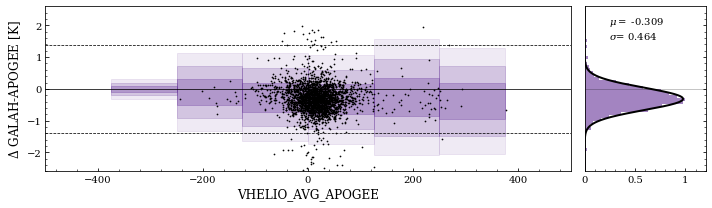

In [5]:
sp.analysis_plot_original(train,test,inputs_features[-1:],outputs_features,ylabel=[r"$\Delta$ GALAH-APOGEE [K]",r"$\Delta$ GALAH-APOGEE",r"$\Delta$ GALAH-APOGEE",r"$\Delta$ GALAH-APOGEE"],namefile_plot="")

-------------------------------------------------------------------------------------------------------------------------
## 4. Train the SpectroTranslator

depth:= 1, width: 64, target: 128
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
depth:= 2, width: 128, target: 256
depth:= 3, width: 256, target: 512
Central layer, width: 512, target: 512
depth:= 3p, width: 512, target: 256
depth:= 2p, width: 256, target: 128
depth:= 1p, width: 128, target: 64
 
Learning Rate: 0.001
Learning Rate: 0.0001
Learning Rate: 1e-05


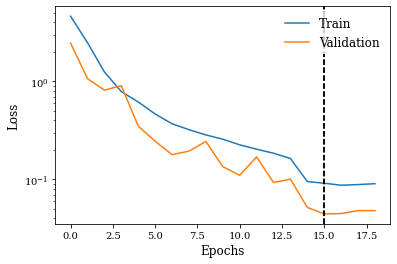

80/80 [==============================] - 1s 7ms/step


In [6]:
####################################################################
## ANN parameters

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

optimizer  = Adam() # Adam optimization
epochs = 20
depth  = 3  # Depth of the Network 
st_features= 64 # Number of standard features in the fist layer
batch_size = 4096 # Define the number of stars per batch
loss_func  = "MAE"  
learning_rate=[1e-3,1e-4,1e-5] # Learning rate
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5,restore_best_weights=True)


  
## Prepare the dataset for the the ML learning 
if(True):# If first ANN, learn the normalization of the input/outputs
    inputs_data_train,outputs_data_train,inputs_data_test,outputs_data_test,scaler_in,scaler_out=sp.prepare_dataset_training(train,test,inputs_features,outputs_features)
else: # Else use the existing normalization
    inputs_data_train,outputs_data_train,inputs_data_test,outputs_data_test,scaler_in,scaler_out=sp.prepare_dataset_applying(train,test,inputs_features,outputs_features,"scaler_in_extrinsic.sav","scaler_out_extrinsic.sav")

    
## Train the SpectroTranslator
ANN=sp.train_SpectroTranslator(inputs_data_train,outputs_data_train,inputs_data_test,outputs_data_test,outputs_features,learning_rate,es,optimizer,epochs,batch_size,loss_func,depth=depth,st_features=st_features,name_plotloss=None,extrinsic=True)


## Get the predicted values and store them in the train/test dataFrame
sp.get_TransformedValues(train,ANN,inputs_data_train,outputs_features,scaler_out)
sp.get_TransformedValues(test,ANN,inputs_data_test,outputs_features,scaler_out)




## 5. Save the scaler (normalization) functions and the ANN 

In [7]:
# Save the scaler functions 
pickle.dump(scaler_out, open('scaler_out_extrinsic.sav','wb'))
pickle.dump(scaler_in, open('scaler_in_extrinsic.sav','wb'))


# Save the ANN
filename = 'ANN_extrinsic.tf'
ANN.save(filename)
print ("ANN saved")


INFO:tensorflow:Assets written to: ANN_extrinsic.tf/assets


INFO:tensorflow:Assets written to: ANN_extrinsic.tf/assets


ANN saved


## 6. Make the files containing the data to generate the Quality flags 

In [8]:
sp.make_analysis_flags(inputs_features,outputs_features,train,suffix="_extrinsic")   

## 7. Analysis plots
### 7.1 Compute the residual after the translation

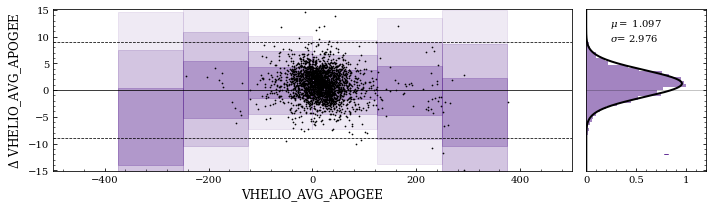

In [9]:
sp.analysis_plot(train,test,inputs_features[-1:],outputs_features,error_outputs,namefile_plot="")

### 7.2 Compute the importance of each inputs (SHAP values)

In [10]:
SHAP=sp.compute_SHAP(ANN,inputs_data_train,inputs_data_test,Nbackground=100,Ntest=100,nsamples=100)

4/4 [==============================] - 0s 6ms/step


313/313 [==============================] - 3s 9ms/step

